In [1]:
import numpy as np
import torch

In [2]:
from utils import vector_padding, extract_entity_relation_pair

### 读取数据

In [3]:
triple_vecs = np.load('./train_triple_vecs.npy', allow_pickle=True)
print(triple_vecs.shape)

(14600,)


In [4]:
question_vecs = np.load('./train_question_vecs.npy', allow_pickle=True)
print(question_vecs.shape)

(14600,)


### 预处理

In [5]:
pvecs = extract_entity_relation_pair(triple_vecs)

extracting pairs 14600/14600...Done!


In [6]:
qvecs = vector_padding(question_vecs)

padding vectors  14600/14600...Done!


### 模型定义

In [7]:
from models.dual_learn import DualTaskQAGSystem

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
net = DualTaskQAGSystem(max_len=qvecs.shape[1], pair_len=pvecs.shape[1], feat_dim=qvecs.shape[-1], max_iter=5,
                        QA_d_model=512, QA_n_heads=8, QA_num_layers=3, QA_dim_feedforward=512, QA_dropout=0.1, QA_act='gelu', 
                        QA_epochs=5, QA_lr=1e-5, QA_weight_l2=1e-12,
                        QG_d_model=512, QG_n_heads=8, QG_num_layers=3, QG_dim_feedforward=512, QG_dropout=0.1, QG_act='gelu', 
                        QG_epochs=5, QG_lr=1e-5, QG_weight_l2=1e-12,
                        batch_size=1024, device=device)

In [10]:
net.preprocess_data(qvecs, pvecs)

Question vectors shape: torch.Size([14600, 26, 300])
Entity-Relation pairs shape: torch.Size([14600, 2, 300])
Step:0  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:1  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:2  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:3  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:4  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:5  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:6  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:7  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:8  question v

(<torch.utils.data.dataloader.DataLoader at 0x7fc1d489ccc0>, 15)

### 加载训练好的模型（如果有的话）

In [11]:
net = torch.load("./checkpoints/best_QG.net")

### 训练

In [11]:
loss_QA, loss_QG_en, loss_QG_re = net.train()

--------------- Iteration 1 ---------------
-- trainning QA model --
epoch=1, loss=0.172302, time=3.66s per epoch
epoch=2, loss=0.138490, time=3.60s per epoch
epoch=3, loss=0.126418, time=3.64s per epoch
epoch=4, loss=0.119411, time=3.63s per epoch
epoch=5, loss=0.114603, time=3.64s per epoch
-- trainning QG model --
epoch=1, loss=0.538720, time=3.59s per epoch
epoch=2, loss=0.441621, time=3.63s per epoch
epoch=3, loss=0.410825, time=3.64s per epoch
epoch=4, loss=0.389552, time=3.59s per epoch
epoch=5, loss=0.367319, time=3.63s per epoch
--------------- Iteration 2 ---------------
-- trainning QA model --
epoch=1, loss=0.113790, time=3.64s per epoch
epoch=2, loss=0.109322, time=3.61s per epoch
epoch=3, loss=0.106503, time=3.64s per epoch
epoch=4, loss=0.104632, time=3.61s per epoch
epoch=5, loss=0.103254, time=3.65s per epoch
-- trainning QG model --
epoch=1, loss=0.491517, time=3.67s per epoch
epoch=2, loss=0.420016, time=3.63s per epoch
epoch=3, loss=0.395464, time=3.59s per epoch
ep

### 可视化

In [12]:
import matplotlib.pyplot as plt

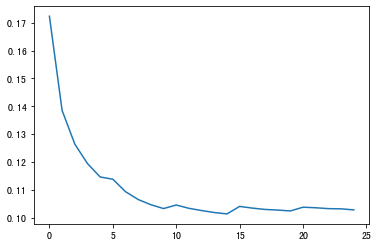

In [13]:
plt.plot(loss_QA)

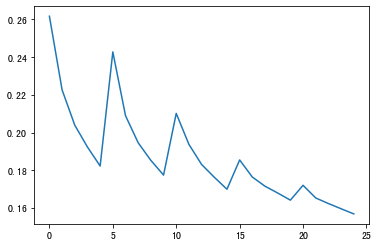

In [14]:
plt.plot(loss_QG_en)

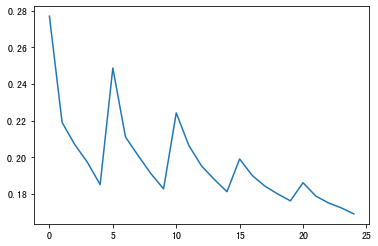

In [15]:
plt.plot(loss_QG_re)

### 获取输出向量示例

In [12]:
question = qvecs[100:101, :] # 取一例 注意维度必须为3维
print(question.shape)

torch.Size([1, 26, 300])


In [13]:
ans_entity, ans_relation = net.predict_answer(question) # 输出实体与关系的embedding
print(ans_entity.shape, ans_relation.shape)

torch.Size([1, 300]) torch.Size([1, 300])


In [14]:
pair = pvecs[50:51, :] # 同样地，必须为三维
pair = torch.tensor(pair, dtype=torch.float32)
print(pair.shape)

torch.Size([1, 2, 300])


In [15]:
gen_question = net.generate_question(pair)
print(gen_question.shape)

torch.Size([1, 26, 300])
